# Agenda
1. Introduction - EDA - Preprocessing

2. Standalone (Baseline) Models

*   Image-only Model (Keras CNN)

      * Tuning hyperparameters with GridSearch

*   Title-only Model (TF-IDF/RNN)

3. Combined Models

*   TF-IDF + CNN Model

*   Bert + CNN Model

*   GPT + CNN Model

4. Application

5. Possible Future Improvements

# Set up and download data

In [ ]:
%%capture
# install stylecloud to create word clouds
! pip install stylecloud

In [ ]:
# mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# change the working directory
%cd /content/gdrive/MyDrive/Colab Notebooks/CPSC 4830/Final Exam

/content/gdrive/MyDrive/Colab Notebooks/CPSC 4830/Final Exam


In [ ]:
# provide the config path to kaggle.json
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive"

# /content/gdrive/My Drive/CPSC-4830/Final/kaggle is the path where kaggle.json is present in the Google Drive

# download
# ! kaggle competitions download -c shopee-product-matching

#%%capture
#unzipping the zip files and deleting the zip files
#! unzip \*.zip  && rm *.zip

# Libraries

In [ ]:
# import libraries
import os
import operator
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
import stylecloud
from PIL import Image as PILImage
from IPython.display import Image

%matplotlib inline

# Load Data

## Tabular data

In [ ]:
# train
train = pd.read_csv('Raw Files/train.csv')
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [ ]:
# test
test = pd.read_csv('Raw Files/test.csv')
test.head()

,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


## Image data

In [ ]:
# define the path to train_images and test_images folder
train_path = 'Raw Files/train_images/'
test_path = 'Raw Files/test_images/'

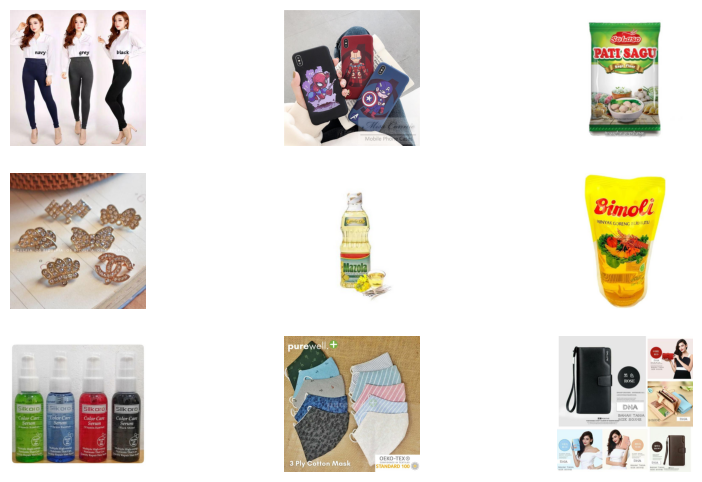

In [ ]:
# plot 9 random train images
rand = np.random.choice(range(len(train)), size = 9)

plt.figure(figsize = (10, 6))

for i in range(9):
  plt.subplot(3, 3, i+1)
  img = train_path + train['image'].iloc[rand[i]]
  plt.axis('off')
  img = plt.imread(img)
  plt.imshow(np.asarray(img))

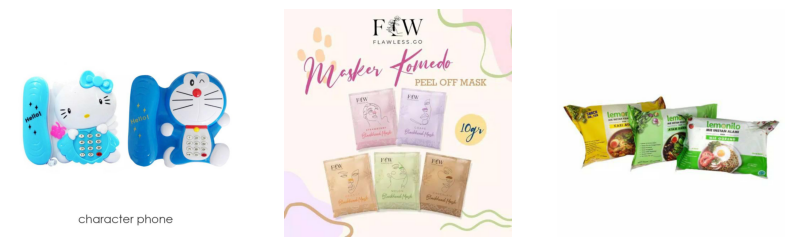

In [ ]:
# plot test images
plt.figure(figsize = (10, 6))

for i in range(3):
  plt.subplot(1, 3, i+1)
  img = test_path + test['image'].iloc[i]
  plt.axis('off')
  img = plt.imread(img)
  plt.imshow(np.asarray(img))

# Overall structure of the data

## Tabular data

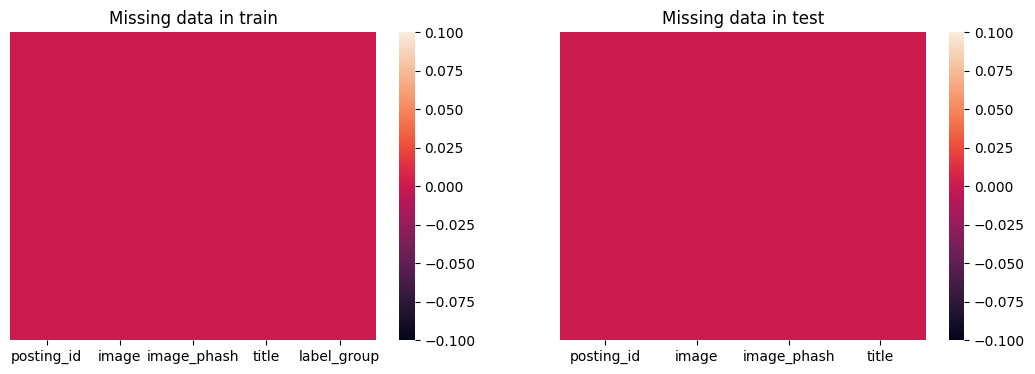

In [ ]:
# visualize missing data
fig, axs = plt.subplots(1, 2, figsize = (13, 4))

sns.heatmap(train.isnull(), ax = axs[0])
sns.heatmap(test.isnull(), ax = axs[1])

axs[0].set_title('Missing data in train')
axs[1].set_title('Missing data in test')

for ax in axs:
    ax.set_yticks([])

plt.show()

In [ ]:
# get number of unique and duplicate values in each column
unique_counts_train = train.nunique()
unique_counts_test = test.nunique()
duplicates_train = train.shape[0] - unique_counts_train
duplicates_test = test.shape[0] - unique_counts_test

# create a new dataframe to store the results
unique_train = pd.DataFrame({'Column': unique_counts_train.index,
                          'Unique Values': unique_counts_train.values,
                          'Duplicate Values': duplicates_train.values})
unique_test = pd.DataFrame({'Column': unique_counts_test.index,
                          'Unique Values': unique_counts_test.values,
                          'Duplicate Values': duplicates_test.values})

# print the pretty table
print(f'\033[1mTrain Dataset :\033[0m {train.shape[0]} rows, {train.shape[1]} columns\n')
print(unique_train.to_markdown(index = False))
print(f'\n\n\033[1mTest Dataset :\033[0m {test.shape[0]} rows, {test.shape[1]} columns\n')
print(unique_test.to_markdown(index = False))

print(f'\n\n\033[1m{len(os.listdir(train_path))}\033[0m images in the train_images folder')
print(f'\033[1m{len(os.listdir(test_path))}\033[0m images in the test_images folder')

Train Dataset : 34250 rows, 5 columns

| Column      |   Unique Values |   Duplicate Values |
|:------------|----------------:|-------------------:|
| posting_id  |           34250 |                  0 |
| image       |           32412 |               1838 |
| image_phash |           28735 |               5515 |
| title       |           33117 |               1133 |
| label_group |           11014 |              23236 |


Test Dataset : 3 rows, 4 columns

| Column      |   Unique Values |   Duplicate Values |
|:------------|----------------:|-------------------:|
| posting_id  |               3 |                  0 |
| image       |               3 |                  0 |
| image_phash |               3 |                  0 |
| title       |               3 |                  0 |


32412 images in the train_images folder
3 images in the test_images folder


## Image shapes

In [ ]:
# function to count the number of unique image shapes (width, height, number of channels)
def get_img_shape(folder_path):
  # define an empty dictiontary to store the results
  img_shape = {}

  # loop through each image file in the folder
  for img_file in os.listdir(folder_path):

    # path to the image
    file_path = os.path.join(folder_path, img_file)

    # open the image
    with PILImage.open(file_path) as img:

      # get the shape of the image
      shape = img.size + (len(img.getbands()),)

      # append the shape of image to the dictionary
      img_shape[shape] = img_shape.get(shape, 0) + 1

  return img_shape # a dictionary {'(width, height)': count}

In [ ]:
# get the shape of images in the train_images and test_images folder
train_img_shape = get_img_shape(train_path)
test_img_shape = get_img_shape(test_path)

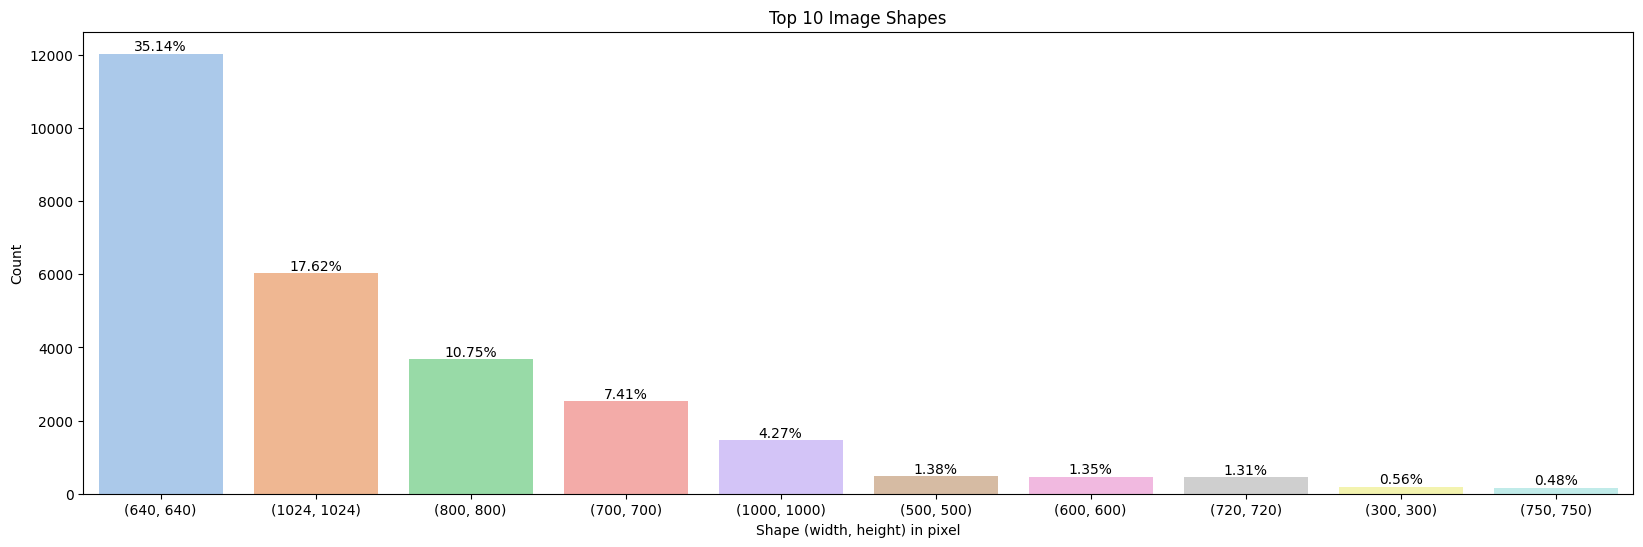

In [ ]:
# plot of top 10 image shapes

# sort the dictionary of training image shapes in descending order of total count
sorted_img_shape = sorted(train_img_shape.items(), key = lambda x: x[1], reverse = True)
top10_shape = dict(sorted_img_shape[:10])

# extract x and y data
x = [f'({shape[0]}, {shape[1]})' for shape in top10_shape.keys()] # image shapes
y = list(top10_shape.values()) # counts

# bar plot
fig, ax = plt.subplots(figsize = (20, 6))
sns.barplot(x = x, y = y, palette = 'pastel', ax = ax, order = x)
plt.xlabel('Shape (width, height) in pixel')
plt.ylabel('Count')
plt.title('Top 10 Image Shapes')

# add the percentage (of the entire train dataset)
for i, v in enumerate(y):
    pct = (v/len(train))*100
    bar_height = ax.patches[i].get_height()
    ax.text(i, bar_height, f'{pct:.2f}%', ha = 'center', va = 'bottom')

plt.show()

In [ ]:
# counts of each unique testing image shape
test_img_shape

{(1000, 1000, 3): 1, (640, 640, 3): 2}

In [ ]:
# unique values of the number of color channels
num_channels = len(set([t[2] for t in train_img_shape.keys()]))
num_channels

1

In [ ]:
# sort the image shapes in descending order and see the top 10 largest shapes
sorted_key_largest = dict(sorted(train_img_shape.items(),
                          key = lambda x: operator.itemgetter(0)(x),
                          reverse = True))
dict(list(zip(sorted_key_largest.keys(), sorted_key_largest.values()))[:10])

{(5000, 5000, 3): 1,
 (4500, 4501, 3): 1,
 (4168, 4168, 3): 2,
 (4168, 4167, 3): 1,
 (4167, 4167, 3): 2,
 (2084, 2084, 3): 1,
 (2083, 2083, 3): 8,
 (2000, 2000, 3): 1,
 (1771, 1771, 3): 1,
 (1668, 1667, 3): 1}

In [ ]:
# sort the image shapes in descending order and see the top 10 smallest shapes
sorted_key_smallest = dict(sorted(train_img_shape.items(),
                                  key = lambda x: operator.itemgetter(0)(x),
                                  reverse = False))
dict(list(zip(sorted_key_smallest.keys(), sorted_key_smallest.values()))[:10])

{(100, 100, 3): 1,
 (110, 110, 3): 1,
 (130, 130, 3): 1,
 (133, 133, 3): 1,
 (155, 155, 3): 1,
 (176, 176, 3): 1,
 (187, 187, 3): 1,
 (194, 194, 3): 8,
 (195, 195, 3): 1,
 (200, 200, 3): 20}

There is only 1 unique value for the number of color channels, meaning all training images have 3 color channels (RGB).

The majority of the training images are in square dimension. 35.14% of all training images are 640 x 640. The largest image dimension is 5000 x 5000, while the smallest is 100 x 100. Of the 3 testing images, 2 are also 640 x 640 while the remaining one is 1000 x 1000.

# Column-wise analysis

## Image perceptual hashes

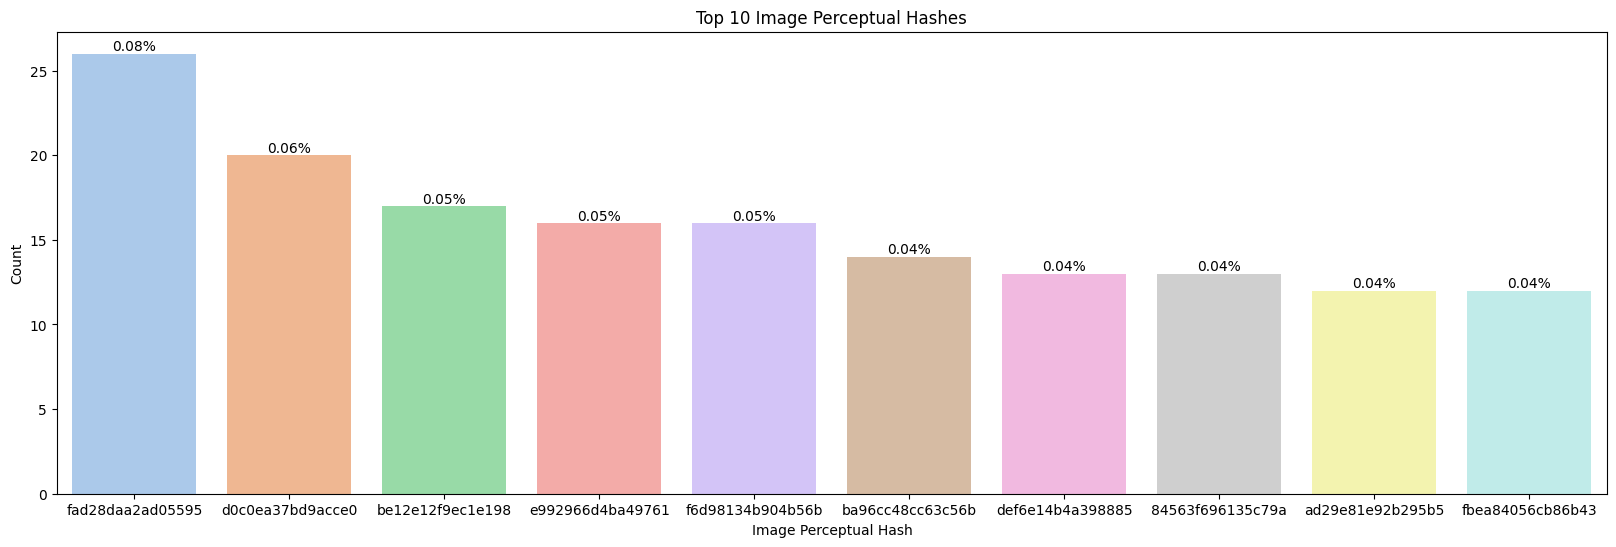

In [ ]:
# plot of top 10 image perceptual hashes

top10_phash = train['image_phash'].value_counts()[:10]

# extract x and y data
x = top10_phash.index.to_list() # hashes
y = top10_phash.to_list() # counts

# bar plot
fig, ax = plt.subplots(figsize = (20, 6))
sns.barplot(x = x, y = y, palette = 'pastel', ax = ax, order = x)
plt.xlabel('Image Perceptual Hash')
plt.ylabel('Count')
plt.title('Top 10 Image Perceptual Hashes')

# # add the percentage (of the entire train dataset)
for i, v in enumerate(y):
    pct = (v/len(train))*100
    bar_height = ax.patches[i].get_height()
    ax.text(i, bar_height, f'{pct:.2f}%', ha = 'center', va = 'bottom')

plt.show()

## Titles

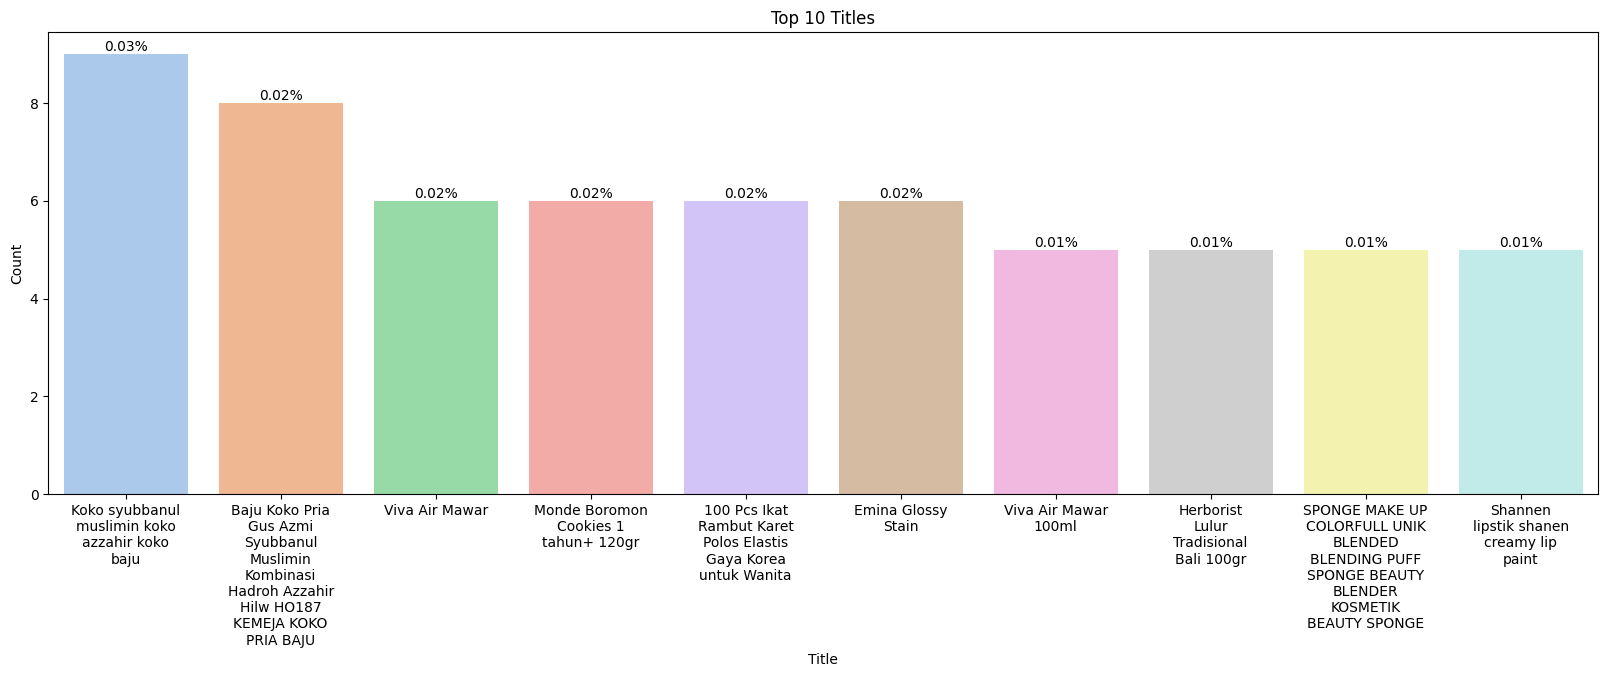

In [ ]:
# plot of top 10 titles
top10_title = train['title'].value_counts()[:10]

# extract x and y data
x = top10_title.index.to_list() # titles
y = top10_title.to_list() # counts

# wrap the titles in the x-axis into multiple lines
x_labels = [ '\n'.join(textwrap.wrap(str(label), width = 14)) for label in x ]

# bar plot
fig, ax = plt.subplots(figsize = (20, 6))
sns.barplot(x = x, y = y, palette = 'pastel', ax = ax, order = x)
plt.xlabel('Title')
plt.ylabel('Count')
plt.title('Top 10 Titles')
plt.xticks(range(len(x)), x_labels)


# # add the percentage (of the entire train dataset)
for i, v in enumerate(y):
    pct = (v/len(train))*100
    bar_height = ax.patches[i].get_height()
    ax.text(i, bar_height, f'{pct:.2f}%', ha = 'center', va = 'bottom')

plt.show()

Titles are not completely English. In fact, most are in Indonesian with some English words mixed in. Even so, the most common word is ORIGINAL.

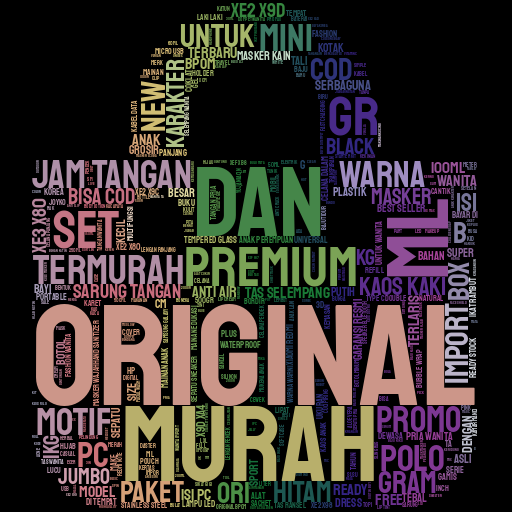

In [ ]:
# word cloud for titles in the train dataset
stylecloud.gen_stylecloud(text = ' '.join(train['title']),
                                         icon_name = 'fas fa-shopping-bag',
                                         palette = 'cartocolors.qualitative.Safe_7',
                                         background_color = 'black',
                                         gradient = 'horizontal',
                                         size = 512)
Image(filename = "./stylecloud.png", width = 512, height = 512)

After titles are translated from Indonesian to English, the most recurrent words are ORIGINAL, CHEAP, SET, CHEAPEST, PREMIUM. They are mostly words that aim to optimize the search engine.

Also quite noticeable are words like CHILDREN, WOMEN, BABY, T SHIRT, MASK, which are categories of product or demographics that most products are advertised to or focused on. This might be worth noting as we proceed to do classification.

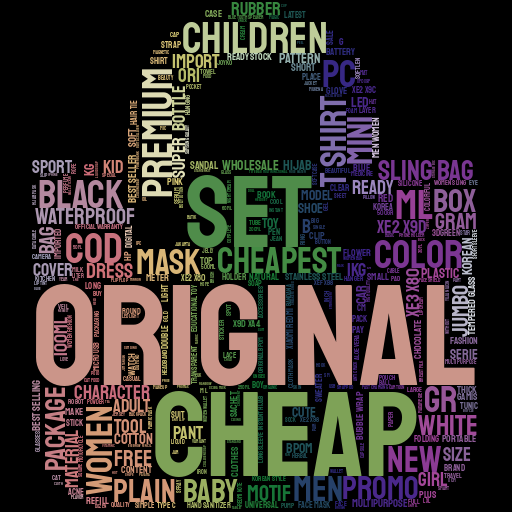

In [ ]:
# word cloud for titles translated from Indonesian to English
train_trans = pd.read_csv('data/train_translated.csv')

stylecloud.gen_stylecloud(text = ' '.join(train_trans['title_translate']),
                                         icon_name = 'fas fa-shopping-bag',
                                         palette = 'cartocolors.qualitative.Safe_7',
                                         background_color = 'black',
                                         gradient = 'horizontal',
                                         size = 512)
Image(filename = "./stylecloud.png", width = 512, height = 512)


## Label groups

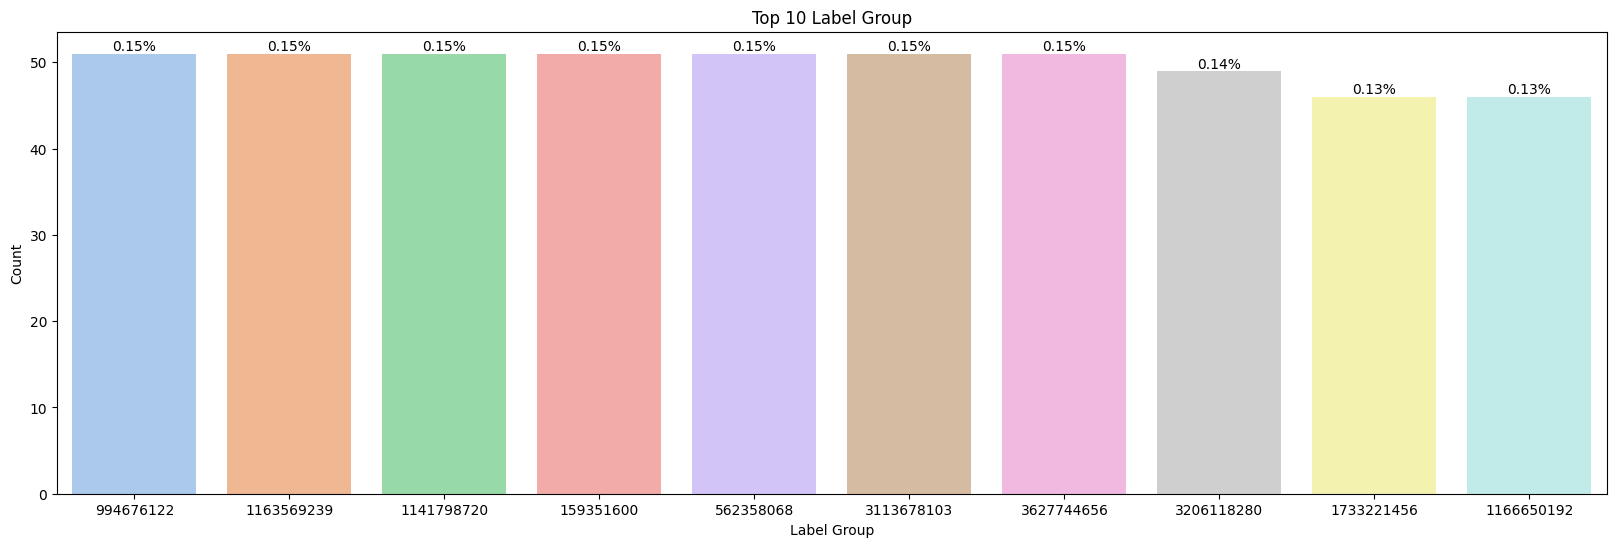

In [ ]:
# plot of top 10 label groups by image count

top10_lg = train['label_group'].value_counts()[:10]

# extract x and y data
x = top10_lg.index.to_list() # label groups
y = top10_lg.to_list() # counts

# bar plot
fig, ax = plt.subplots(figsize = (20, 6))
sns.barplot(x = x, y = y, palette = 'pastel', ax = ax, order = x)
plt.xlabel('Label Group')
plt.ylabel('Count')
plt.title('Top 10 Label Group')

# # add the percentage (of the entire train dataset)
for i, v in enumerate(y):
    pct = (v/sum(train['label_group'].value_counts()))*100
    bar_height = ax.patches[i].get_height()
    ax.text(i, bar_height, f'{pct:.2f}%', ha = 'center', va = 'bottom')

plt.show()

# Duplicates analysis

## Images

**1. image perceptual hashes**
*   If images are duplicates of each other, they share the same perceptual hash

**2. titles**
*   No duplicated images have the same titles
*   Most duplicated images (74.5%) have 2 different titles

**3. label groups**
*   96.3% of duplicated images belong to the same label groups
*   3.7% of duplicated images belong to different label groups

In [ ]:
## function to plot the distribution of duplicates across numbers of unique values in other columns

def plot_dup(dup_df, group_var, column, show_pct = True):
    # the number of unique values for each group in a column
    group = dup_df.groupby(group_var)[column].nunique()

    # frequency distribution of the unique values in a column
    counts = {}
    for num_groups in group.unique():
        counts[num_groups] = sum(group == num_groups)

    # bar plot
    ax = sns.barplot(x = list(counts.keys()),
                     y = list(counts.values()),
                     palette = 'pastel')

    # option to turn the pcerntages on/off
    if show_pct:
      # add text labels to each bar with percentages
      total = sum(counts.values())
      for i, v in enumerate(counts.values()):
          bar_height = ax.patches[i].get_height()
          ax.text(i, bar_height + 5, f'{v/total:.1%}', ha = 'center', fontsize = 8)

    # format axes, labels and titles
    plt.xlabel(f'Number of unique {column}')
    plt.ylabel(f'Count')
    plt.title(f'Distribution of duplicated {group_var} across\nnumbers of unique {column}')
    ax.tick_params(bottom = False, top = False, left = False, right = False)

In [ ]:
## function to plot images with the same image name/hash/title/label group

def plot_img(group):
  # number of images in a group
  num_img = len(group)

  # define number of columns and rows for subplots
  num_cols = min(num_img, 3)
  num_rows = (num_img + num_cols - 1) // num_cols

  # define figure size and spaces between subplots
  plt.figure(figsize = (num_cols*3, num_rows*3))
  plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

  # plot every images in the group
  for i in range(len(group)):
      plt.subplot(num_rows, num_cols, i+1)
      img = train_path + group['image'].iloc[i]
      plt.axis('off')
      img = plt.imread(img)
      plt.imshow(np.asarray(img))

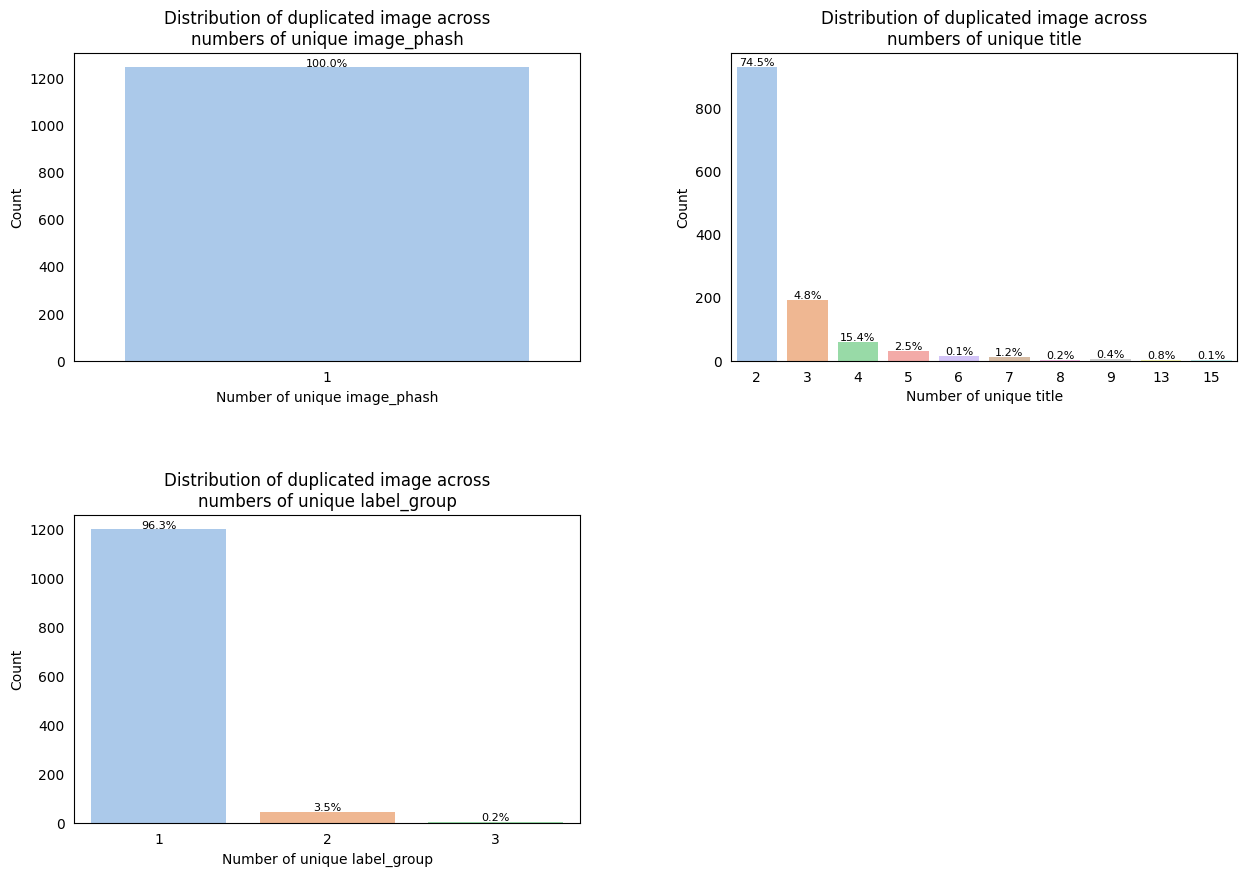

In [ ]:
# dataframe of all rows with duplicates in the image column
img_dup = train[train.duplicated('image', keep = False)]

column = ['image_phash', 'title', 'label_group']

plt.figure(figsize = (15, 10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(len(column)):
    plt.subplot(2, 2, i+1)
    plot_dup(dup_df = img_dup,
             group_var = 'image',
             column = column[i])

plt.show()

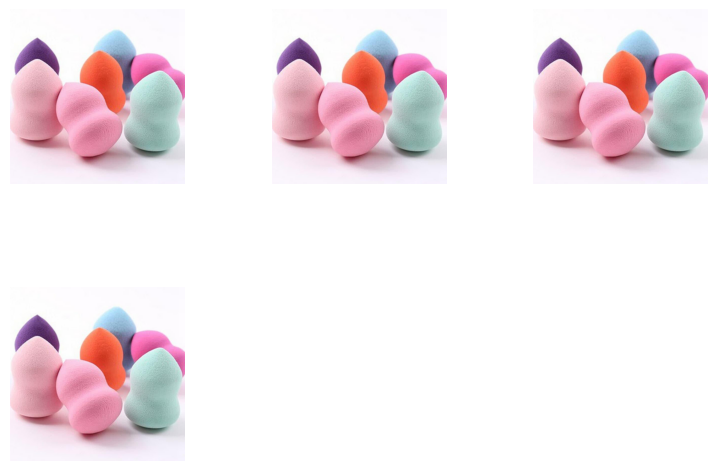

In [ ]:
## plot all duplicated images in a group

# nth group in the duplicated images dataframe
n_group = 30

# extract and plot all images in the nth group
group1 = img_dup.groupby('image').get_group(img_dup['image'].unique()[n_group - 1])
plot_img(group1)

## Image perceptual hashes

If the image hashes are the same, in most cases:
*   They represent 2 different images
*   They have 2 different titles
*   They belong to the same label group

Plotting the images with the same hashes shows that they are identical or are very similar.

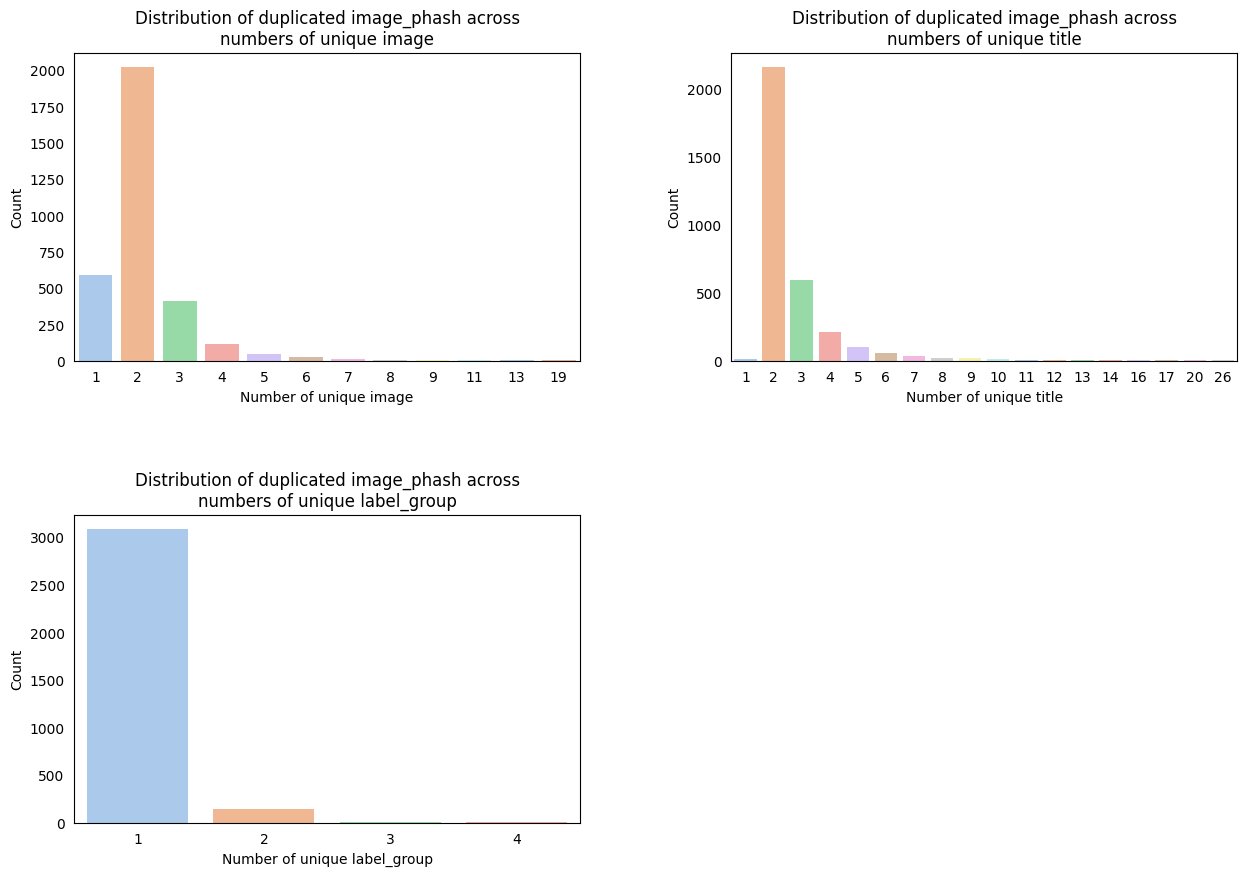

In [ ]:
# dataframe of all rows with duplicates in the image_phash column
phash_dup = train[train.duplicated('image_phash', keep = False)]

column = ['image', 'title', 'label_group']

plt.figure(figsize = (15, 10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(len(column)):
    plt.subplot(2, 2, i+1)
    plot_dup(dup_df = phash_dup,
             group_var = 'image_phash',
             column = column[i],
             show_pct = False)

plt.show()

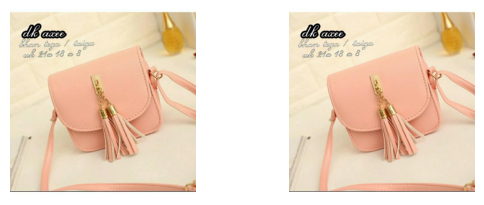

In [ ]:
## plot all images with the same perceptual hash

# nth group in the duplicated hashes dataframe
n_group = 1000

# extract and plot all images in the nth group
group2 = phash_dup.groupby('image_phash').get_group(phash_dup['image_phash'].unique()[n_group - 1])
plot_img(group2)

## Titles

No title exclusively indicates one image. The majority of duplicates titles indicate 2 different images or have 2 different image hashes, but usually belongs to the same label group.

Plotting of the images with the same title shows that they are different images of the same or very similar product.

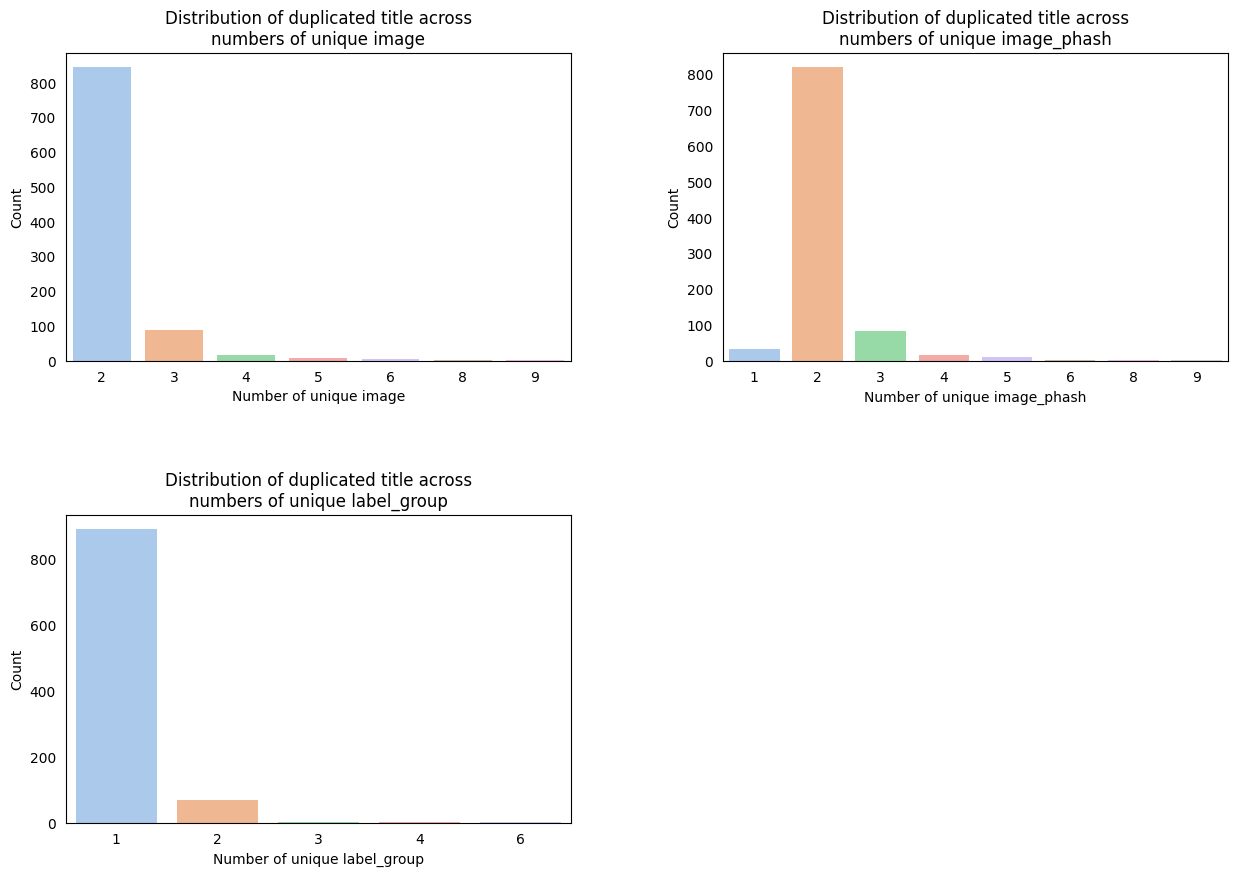

In [ ]:
# dataframe of all rows with duplicates in the title column
title_dup = train[train.duplicated('title', keep = False)]

column = ['image', 'image_phash', 'label_group']

plt.figure(figsize = (15, 10))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(len(column)):
    plt.subplot(2, 2, i+1)
    plot_dup(dup_df = title_dup,
             group_var = 'title',
             column = column[i],
             show_pct = False)

plt.show()

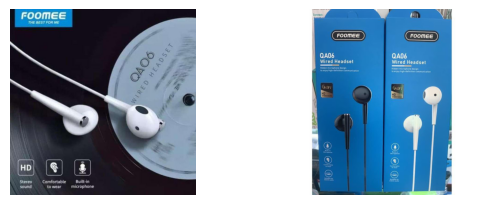

In [ ]:
## plot all images with the same title

# nth group in the duplicated titles dataframe
n_group = 10

# extract and plot all images in the nth group
group3 = title_dup.groupby('title').get_group(title_dup['title'].unique()[n_group - 1])
plot_img(group3)

## Label Groups

No label group exclusively represents one image. The majority of duplicates in label groups have 2 different images, image hashes or titles.

Plotting of the images in the same label group shows that they are different images of the same or very similar product.

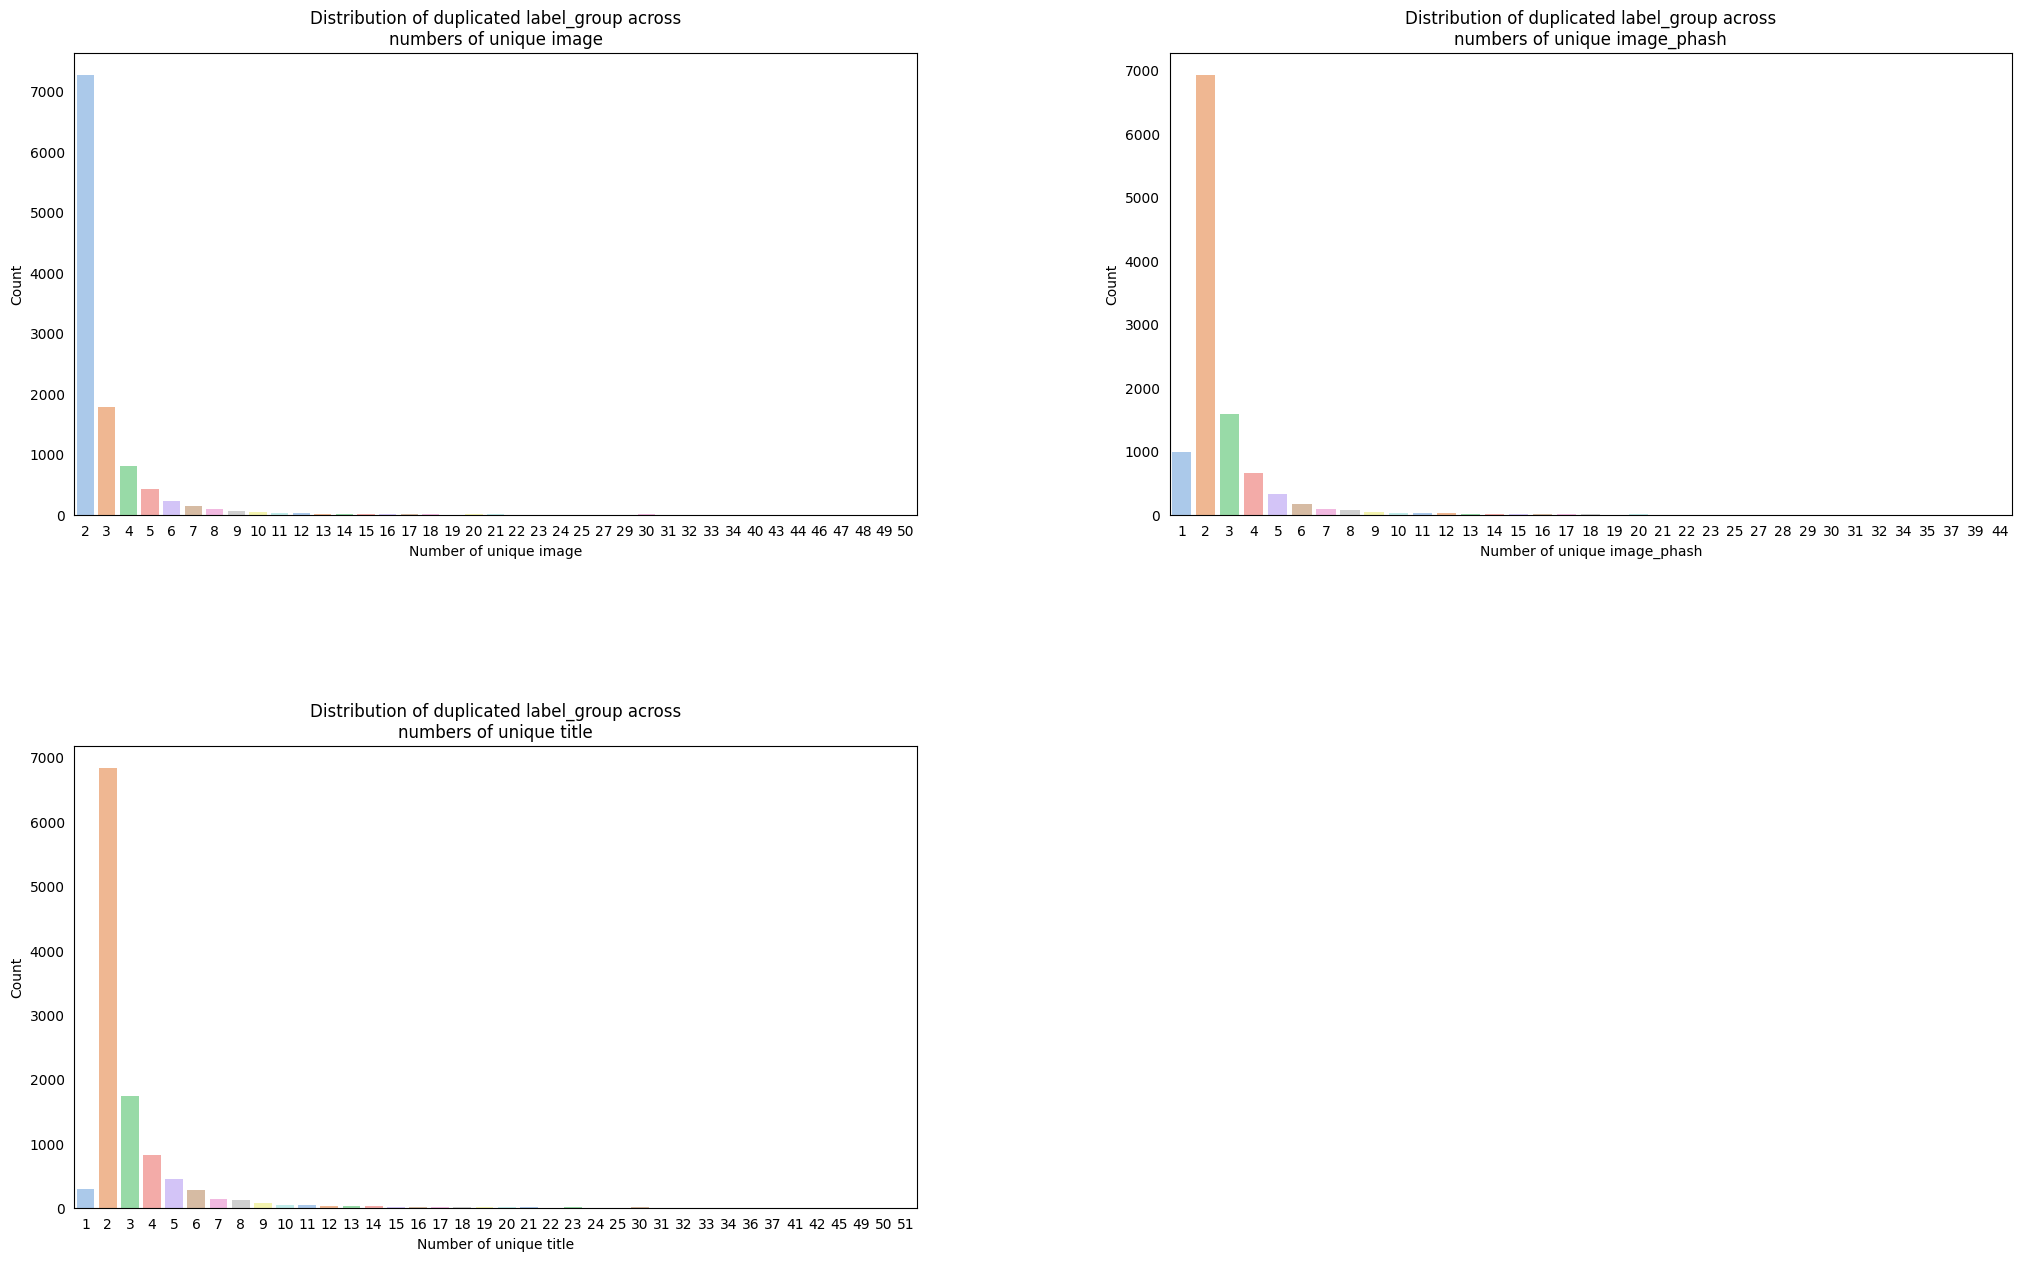

In [ ]:
# dataframe of all rows with duplicates in the label_group column
lg_dup = train[train.duplicated('label_group', keep = False)]

column = ['image', 'image_phash', 'title']

plt.figure(figsize = (25, 15))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(len(column)):
    plt.subplot(2, 2, i+1)
    plot_dup(dup_df = lg_dup,
             group_var = 'label_group',
             column = column[i],
             show_pct = False)

plt.show()

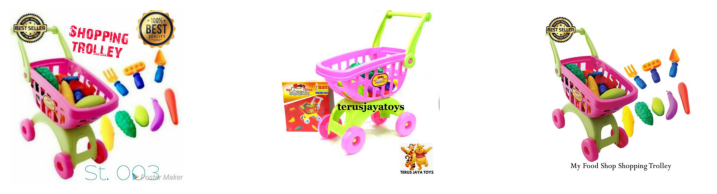

In [ ]:
## plot all images with the same label group

# nth group in the duplicated label groups dataframe
n_group = 30

# extract and plot all images in the nth group
group4 = lg_dup.groupby('label_group').get_group(lg_dup['label_group'].unique()[n_group - 1])
plot_img(group4)